# Technical Challenge

Import Libraries

In [473]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

#for plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#hypothesis testing
from scipy.stats import ttest_1samp

#train-test-split
from sklearn.model_selection import train_test_split

#scaling numerical variables
from sklearn.preprocessing import MinMaxScaler # do not use the function Normalise() - it does something entirely different

#categorical variables
from sklearn.preprocessing import OneHotEncoder

#for regression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# #for stats
# import scipy.stats as stats

In [474]:
data = pd.read_csv('measurements.csv')

## 1. Exploratory data analysis

- Exploratory data analysis  
- Get to know the domain  
- Explore your data  
- Clean your data  
- Take a look and find connections between data  

In [475]:
display(data.shape)
data.head()

(388, 12)

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28,5,26,"21,5",12,NaN,E10,0,0,0,45,E10
1,12,"4,2",30,"21,5",13,NaN,E10,0,0,0,NaN,NaN
2,"11,2","5,5",38,"21,5",15,NaN,E10,0,0,0,NaN,NaN
3,"12,9","3,9",36,"21,5",14,NaN,E10,0,0,0,NaN,NaN
4,"18,5","4,5",46,"21,5",15,NaN,E10,0,0,0,NaN,NaN


- displayed distance [km]
- consume [L/km]
- the average speed (km/h), 
- the temperature i had inside (°C), 
- the temperature outside (°C)
- anything special that happened, 
- the gas type i was using
- if it was raining, 
- if the air condition was on, 
- if it was sunny enough that the car felt warm when i started it… 

I have also two columns saying how much and which gas type I was buying. 
Careful with those. The numbers don't add exactly up, because I note only the rides 
that occur under certain conditions: If the car was not cooling down enough to have 
another independent measure from the one before, i don't note it.

I started writing down the data in November, changed to SP98 in winter, and back to E10 in spring.

In [476]:
data.dtypes
# We will have to change/convert distance, consume, temp_inside, refill liters to numerical.

distance         object
consume          object
speed             int64
temp_inside      object
temp_outside      int64
specials         object
gas_type         object
AC                int64
rain              int64
sun               int64
refill liters    object
refill gas       object
dtype: object

In [477]:
# standardize header names
data.columns = [e.lower().replace(' ', '_') for e in data.columns]

In [478]:
#convert to numeric
data['distance'] = data['distance'].str.replace(',','.')
data['distance'] = pd.to_numeric(data['distance'], errors='coerce')
data['consume'] = data['consume'].str.replace(',','.')
data['consume'] = pd.to_numeric(data['consume'], errors='coerce')
data['temp_inside'] = data['temp_inside'].str.replace(',','.')
data['temp_inside'] = pd.to_numeric(data['temp_inside'], errors='coerce')
data['refill_liters'] = data['refill_liters'].str.replace(',','.')
data['refill_liters'] = pd.to_numeric(data['refill_liters'], errors='coerce')


In [479]:
data.head()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,ac,rain,sun,refill_liters,refill_gas
0,28.0,5.0,26,21.5,12,NaN,E10,0,0,0,45.0,E10
1,12.0,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN
2,11.2,5.5,38,21.5,15,NaN,E10,0,0,0,NaN,NaN
3,12.9,3.9,36,21.5,14,NaN,E10,0,0,0,NaN,NaN
4,18.5,4.5,46,21.5,15,NaN,E10,0,0,0,NaN,NaN


In [480]:
#Check for duplicate rows in the data and remove if any.
sum(data.duplicated()) #check how many rows are duplicated.
data = data.drop_duplicates()
data.shape

(388, 12)

In [481]:
# Check and deal with NaN values:

#Function to check for NaNs:
def get_percentnan(x):
    data_percentnan = pd.DataFrame(x.isna().sum()/len(x)*100)
    data_percentnan = data_percentnan.reset_index()
    data_percentnan.columns = ['header_name', 'percent_nulls']
    data_percentnan = data_percentnan[(data_percentnan['percent_nulls'] > 0)]
    display(data_percentnan)
    return

In [482]:
get_percentnan(data)

,header_name,percent_nulls
3,temp_inside,3.092784
5,specials,76.030928
10,refill_liters,96.649485
11,refill_gas,96.649485


In [483]:
data.columns

Index(['distance', 'consume', 'speed', 'temp_inside', 'temp_outside',
       'specials', 'gas_type', 'ac', 'rain', 'sun', 'refill_liters',
       'refill_gas'],
      dtype='object')

## Having a look at the NaN-Values / Columns:

### Specials:

In [484]:
data[data['specials'].isna()==False]

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,ac,rain,sun,refill_liters,refill_gas
40,12.4,4.0,55,21.5,7,AC rain,E10,1,1,0,NaN,NaN
41,4.5,5.0,29,21.5,7,AC,E10,1,0,0,NaN,NaN
50,11.8,5.1,29,21.5,5,rain,SP98,0,1,0,NaN,NaN
53,13.1,6.1,46,21.5,6,rain,SP98,0,1,0,NaN,NaN
55,153.5,4.9,82,21.5,3,rain,SP98,0,1,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
381,5.5,3.7,33,24.5,28,sun,SP98,0,0,1,NaN,NaN
382,13.6,3.7,33,24.5,28,sun,SP98,0,0,1,NaN,NaN
384,16.1,4.3,38,25.0,31,AC,SP98,1,0,0,NaN,NaN
386,15.4,4.6,42,25.0,31,AC,SP98,1,0,0,NaN,NaN


In [485]:
data['specials'].value_counts()

rain                  32
sun                   27
AC rain                9
ac                     8
AC                     6
snow                   3
sun ac                 3
AC snow                1
half rain half sun     1
AC sun                 1
AC Sun                 1
ac rain                1
Name: specials, dtype: int64

In [486]:
data[data['specials']=='half rain half sun']

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,ac,rain,sun,refill_liters,refill_gas
191,43.7,4.7,44,22.0,9,half rain half sun,SP98,0,1,0,10.0,SP98


Decision to drop the specials column, because the columns ac, rain, sun reflect it already.

In [487]:
#dropping useless columns:
data = data.drop(columns=['specials'], axis=1)

In [488]:
data.head()

,distance,consume,speed,temp_inside,temp_outside,gas_type,ac,rain,sun,refill_liters,refill_gas
0,28.0,5.0,26,21.5,12,E10,0,0,0,45.0,E10
1,12.0,4.2,30,21.5,13,E10,0,0,0,NaN,NaN
2,11.2,5.5,38,21.5,15,E10,0,0,0,NaN,NaN
3,12.9,3.9,36,21.5,14,E10,0,0,0,NaN,NaN
4,18.5,4.5,46,21.5,15,E10,0,0,0,NaN,NaN


In [489]:
get_percentnan(data)

,header_name,percent_nulls
3,temp_inside,3.092784
9,refill_liters,96.649485
10,refill_gas,96.649485


### temp_inside

In [490]:
data[data['temp_inside'].isna()==True]

,distance,consume,speed,temp_inside,temp_outside,gas_type,ac,rain,sun,refill_liters,refill_gas
93,12.4,4.7,43,NaN,10,SP98,0,0,0,NaN,NaN
95,11.8,5.3,52,NaN,11,SP98,0,0,0,NaN,NaN
97,15.7,5.3,33,NaN,9,SP98,0,0,0,NaN,NaN
98,12.9,5.7,35,NaN,9,SP98,0,0,0,NaN,NaN
99,6.4,4.4,37,NaN,10,SP98,0,0,0,NaN,NaN
100,5.3,4.1,34,NaN,9,SP98,0,0,0,NaN,NaN
102,18.8,5.0,62,NaN,9,SP98,0,1,0,NaN,NaN
201,22.2,3.8,42,NaN,15,SP98,0,0,0,NaN,NaN
203,12.6,4.1,33,NaN,17,SP98,0,0,0,NaN,NaN
261,24.5,3.9,50,NaN,15,E10,0,0,1,NaN,NaN


In [491]:
data['temp_inside'].value_counts()

21.5    133
22.0    102
22.5     59
20.0     25
21.0     13
23.0     13
25.0     12
24.5      7
20.5      4
24.0      3
23.5      2
25.5      2
19.0      1
Name: temp_inside, dtype: int64

Strategy: Replacing missing values by mean

In [492]:
data['temp_inside'] = data['temp_inside'].fillna(data['temp_inside'].mean())

### refill_liters and refill_gas

In [493]:
get_percentnan(data)

,header_name,percent_nulls
9,refill_liters,96.649485
10,refill_gas,96.649485


We cannot use these columns it is just to much NaNs

In [494]:
#dropping useless columns:
data = data.drop(columns=['refill_liters'], axis=1)
data = data.drop(columns=['refill_gas'], axis=1)

In [495]:
get_percentnan(data)

,header_name,percent_nulls


### gas_type

In [496]:
data.dtypes

distance        float64
consume         float64
speed             int64
temp_inside     float64
temp_outside      int64
gas_type         object
ac                int64
rain              int64
sun               int64
dtype: object

In [497]:
data['gas_type'].value_counts()

SP98    228
E10     160
Name: gas_type, dtype: int64

### having a look at the data - Visualization

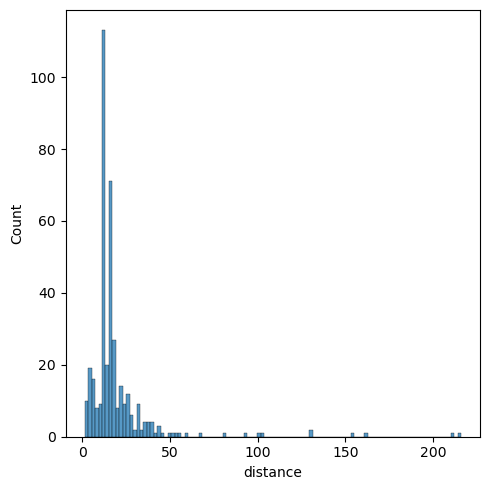

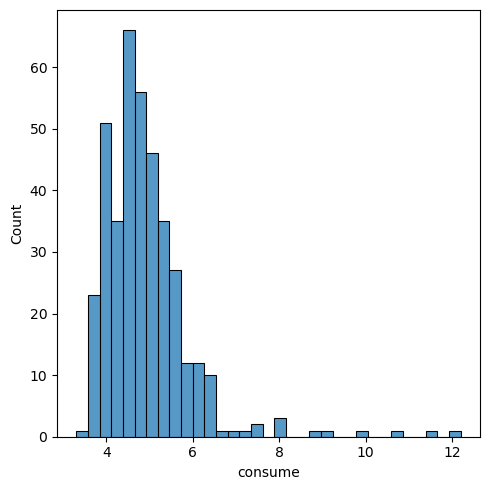

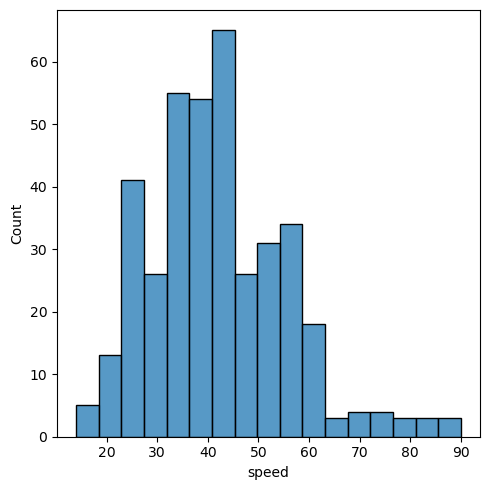

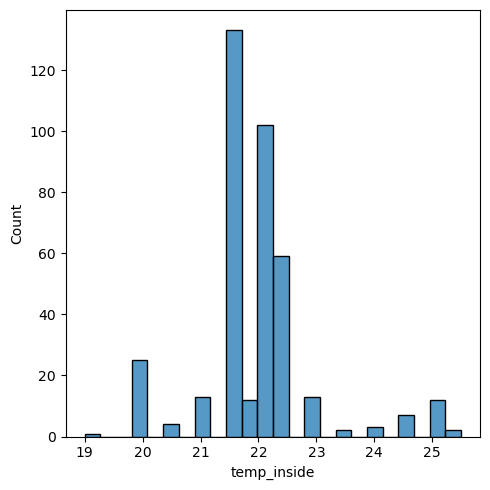

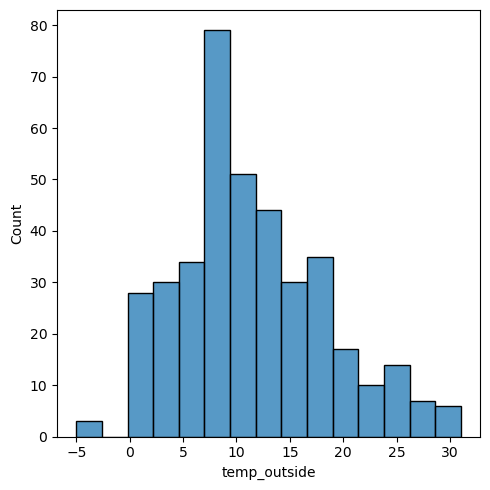

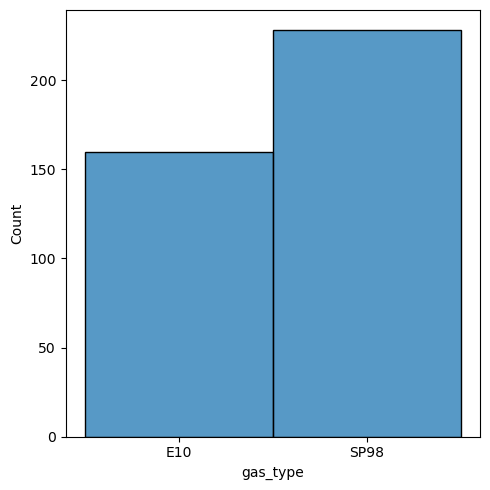

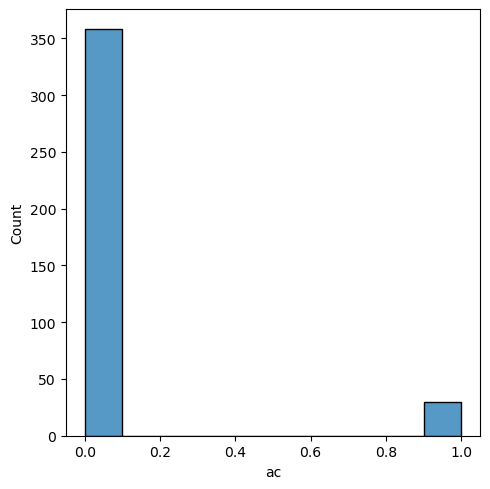

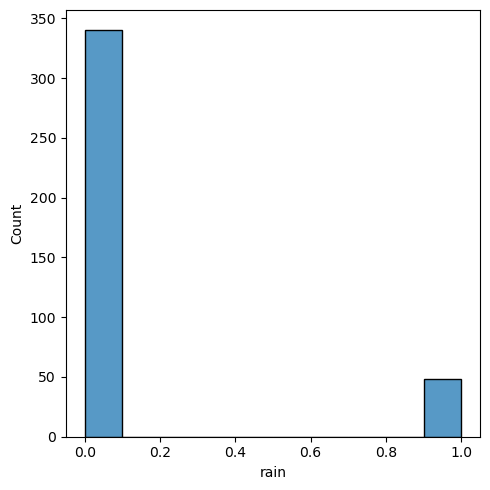

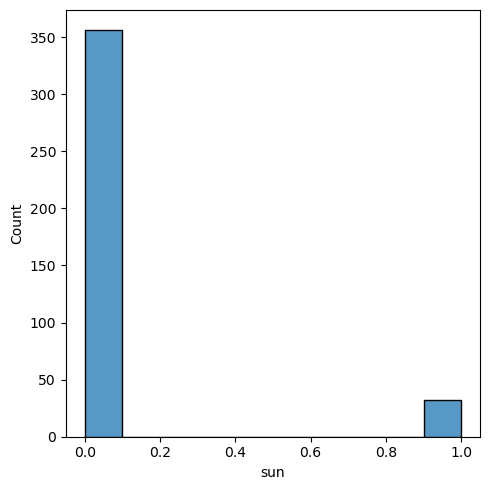

In [498]:
def plot_countplot(data):
    for column in data.columns:
        plt.figure(figsize=(5, 5))
        ax = sns.histplot(data=data, x=column)
        plt.tight_layout()
        plt.show()

plot_countplot(data)

What do we see?

- distance: numerical, continuous --> some outliers above 100 - 200 km
- consume: numerical, continuous 
- speed: numerical, continuous
- temp_inside: numerical, continuous
- temp_outside: numerical, continuous
- gas_type: categorical, 2 categories
- ac: categorical, 2 categories --> already ordinal encoded!
- rain: categorical, 2 categories --> already ordinal encoded!
- sun: categorical, 2 categories --> already ordinal encoded!

In [499]:
data['ac'] = data['ac'].astype(object)
data['rain'] = data['rain'].astype(object)
data['sun'] = data['sun'].astype(object)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f7b6260d280>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7b6260da90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7b62788dc0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f7b6260d670>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f7b6260d640>],
 'means': []}

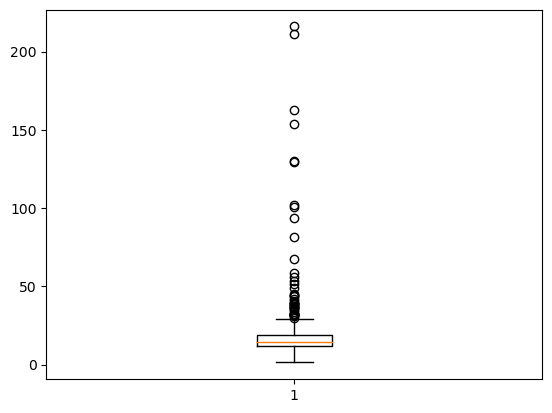

In [500]:
plt.boxplot(data['distance'])

I challenge you to predict the consumption depending on the gas type!

## Predictions

### Do you have any hypothesis ?

The consumption of SP95 E10-fuel is higher than the average consumption of SP98-fuel.

In [501]:
data.head()

,distance,consume,speed,temp_inside,temp_outside,gas_type,ac,rain,sun
0,28.0,5.0,26,21.5,12,E10,0,0,0
1,12.0,4.2,30,21.5,13,E10,0,0,0
2,11.2,5.5,38,21.5,15,E10,0,0,0
3,12.9,3.9,36,21.5,14,E10,0,0,0
4,18.5,4.5,46,21.5,15,E10,0,0,0


In [502]:
data_sp98 = data[data['gas_type'] == 'SP98']
display(data_sp98.shape)
data_sp98.head()

(228, 9)

,distance,consume,speed,temp_inside,temp_outside,gas_type,ac,rain,sun
44,5.4,3.3,32,21.5,7,SP98,0,0,0
45,2.0,9.9,21,21.5,4,SP98,0,0,0
46,14.2,5.1,32,21.5,7,SP98,0,0,0
47,16.0,4.9,25,21.5,8,SP98,0,0,0
48,11.8,4.9,25,21.5,11,SP98,0,0,0


In [503]:
mean_consumption_SP98 = data_sp98['consume'].mean()
mean_consumption_SP98

4.899122807017543

In [504]:
data_e10 = data[data['gas_type'] == 'E10']
display(data_e10.shape)
data_e10.head()

(160, 9)

,distance,consume,speed,temp_inside,temp_outside,gas_type,ac,rain,sun
0,28.0,5.0,26,21.5,12,E10,0,0,0
1,12.0,4.2,30,21.5,13,E10,0,0,0
2,11.2,5.5,38,21.5,15,E10,0,0,0
3,12.9,3.9,36,21.5,14,E10,0,0,0
4,18.5,4.5,46,21.5,15,E10,0,0,0


In [505]:
# H0: car consumption with E10 >= mean consumption of SP98 4.89l/100km
# H1: car consumption with E10 < mean consumption of SP98 4.89l/100km

# One-sided test:
significance = 0.05

stat, pval = ttest_1samp(data_e10['consume'], mean_consumption_SP98)

print("The p-value for the one-tailed test is, with a significance of 5% is",pval/2)
print("The stat-value is",stat, 'positive.')
print('The p-value is higher than 0.05, we have plenty of evidence to support H0. The stat is positive which suggests that the mean consumption is higher than the mean consumption of SP98')

The p-value for the one-tailed test is, with a significance of 5% is 0.32628234198441486
The stat-value is 0.4510546825484683 positive.
The p-value is higher than 0.05, we have plenty of evidence to support H0. The stat is positive which suggests that the mean consumption is higher than the mean consumption of SP98


In [506]:
data_e10['consume'].mean()

4.931250000000001

### Prediction: Predict the car fuel consumption

In [507]:
data.head()

,distance,consume,speed,temp_inside,temp_outside,gas_type,ac,rain,sun
0,28.0,5.0,26,21.5,12,E10,0,0,0
1,12.0,4.2,30,21.5,13,E10,0,0,0
2,11.2,5.5,38,21.5,15,E10,0,0,0
3,12.9,3.9,36,21.5,14,E10,0,0,0
4,18.5,4.5,46,21.5,15,E10,0,0,0


X/y-Split

In [508]:
y = data['consume']
X = data.drop(['consume'], axis=1)

Train/Test-Split

In [509]:
# We do the Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Split in categoricals and numericals

In [510]:
X_num = X.select_dtypes(np.number)
X_cat = X.select_dtypes(object)

transformation on numericals:

In [511]:
numericals_train = X_train.select_dtypes(np.number)
numericals_test = X_test.select_dtypes(np.number)

In [512]:
# Normalizing data: make data range from 0 - 1, instead of from min to max
transformer = MinMaxScaler().fit(numericals_train)
numericals_train_scaled = transformer.transform(numericals_train)
numericals_train_scaled = pd.DataFrame(numericals_train_scaled, columns=X_num.columns)

numericals_test_scaled = transformer.transform(numericals_test)
numericals_test_scaled = pd.DataFrame(numericals_test_scaled, columns=X_num.columns)

transformation on categoricals

In [513]:
categoricals_train= X_train.select_dtypes(object)
categoricals_test= X_test.select_dtypes(object)

In [514]:
categoricals_train.head()

,gas_type,ac,rain,sun
63,SP98,0,0,0
238,E10,0,0,0
132,SP98,0,0,0
101,SP98,1,1,0
351,SP98,0,0,0


We only need to encode the gas_type. the other columns are already encoded.

In [515]:
categoricals_train['gas_type'] = categoricals_train["gas_type"].map({"SP98" : 0, "E10" : 1})
categoricals_test['gas_type'] = categoricals_test["gas_type"].map({"SP98" : 0, "E10" : 1})

Combine train and test-data

In [516]:
X_train_processed = np.concatenate((categoricals_train, numericals_train_scaled),axis=1)
X_test_processed = np.concatenate((categoricals_test, numericals_test_scaled),axis=1)

In [517]:
#Check that every column is numerical!
pd.DataFrame(X_train_processed).select_dtypes(np.object)

,0,1,2,3,4,5,6,7
0,0,0,0,0,0.025605,0.157895,0.384615,0.305556
1,1,0,0,0,0.048883,0.342105,0.538462,0.194444
2,0,0,0,0,0.068901,0.25,0.384615,0.305556
3,0,1,1,0,0.115922,0.75,0.307692,0.361111
4,0,0,0,0,0.068436,0.421053,0.461538,0.611111
...,...,...,...,...,...,...,...,...
305,0,0,0,0,0.003259,0.078947,0.384615,0.416667
306,0,0,0,0,0.751397,0.802632,0.615385,0.166667
307,1,0,0,0,0.068436,0.355263,0.461538,0.472222
308,1,0,0,0,0.071229,0.473684,0.461538,0.833333


Modelling:

In [518]:
def run_pipeline_regr(X_train_processed, X_test_processed, y_train, y_test):
    linreg = LinearRegression()
    dtreg = DecisionTreeRegressor()
    knreg = KNeighborsRegressor()
    mlp = MLPRegressor(max_iter = 700)
    rfreg = RandomForestRegressor()

    model_pipeline = [linreg, dtreg, knreg, mlp, rfreg]
    model_name = [str(x) for x in model_pipeline]
    
    results = {}

    #--------------
    preds_train = {}
    preds_test = {}
    scores_train = {}
    scores_test = {}
    mses_train = {}
    mses_test = {}
    rmses_train = {}
    rmses_test = {}
    maes_train = {}
    maes_test = {}
    
    for model,name in zip(model_pipeline, model_name):
        #Fitting the model
        model.fit(X_train_processed, y_train)
        #Predicted target trainvalues
        y_pred_train = model.predict(X_train_processed)
        preds_train[name] = y_pred_train
        #Predicted target testvalues
        y_pred_test = model.predict(X_test_processed)
        preds_test[name] = y_pred_test

        mean_score_train = np.mean(cross_val_score(model, X_train_processed, y_train, cv = 5))
        scores_train[name] = mean_score_train
        mean_score_test = np.mean(cross_val_score(model, X_test_processed, y_test, cv = 5))
        scores_test[name] = mean_score_test

        mse_train = mean_squared_error(y_pred_train, y_train)
        mse_test = mean_squared_error(y_pred_test, y_test)
        rmse_train = np.sqrt(mse_train)
        rmse_test = np.sqrt(mse_test)
        mae_train = mean_absolute_error(y_pred_train, y_train)
        mae_test = mean_absolute_error(y_pred_test, y_test)

        mses_train[name] = mse_train
        mses_test[name] = mse_test
        rmses_train[name] = rmse_train
        rmses_test[name] = rmse_test
        maes_train[name] = mae_train
        maes_test[name] = mae_test

    return preds_train, scores_train, mses_train, rmses_train, maes_train , preds_test,  scores_test,  mses_test,  rmses_test,  maes_test

In [519]:
preds_train, scores_train, mses_train, rmses_train, maes_train , preds_test,  scores_test,  mses_test,  rmses_test,  maes_test = run_pipeline_regr(X_train_processed, X_test_processed, y_train, y_test)

In [520]:
display(scores_train)
display(scores_test)

{'LinearRegression()': 0.06827548384773274,
 'DecisionTreeRegressor()': -0.15710396437642332,
 'KNeighborsRegressor()': 0.1441651270475533,
 'MLPRegressor(max_iter=700)': 0.14847421982743128,
 'RandomForestRegressor()': 0.4670542332564853}

{'LinearRegression()': -0.409634204694699,
 'DecisionTreeRegressor()': -0.48982260633413865,
 'KNeighborsRegressor()': -0.12006300436344113,
 'MLPRegressor(max_iter=700)': -0.39967446027867404,
 'RandomForestRegressor()': 0.2011661434667885}

The best model seems to be the RandomForestRegressor

In [521]:
# LR = linear_model.LinearRegression()
# LR.fit(X_train_processed,y_train)
# y_predicted_train = LR.predict(X_train_processed)
# y_predicted_test = LR.predict(X_test_processed)
# train_score= r2_score(y_train, y_predicted_train)
# test_score = r2_score(y_test, y_predicted_test)
# display(train_score)
# display(test_score)

Correlation Matrix

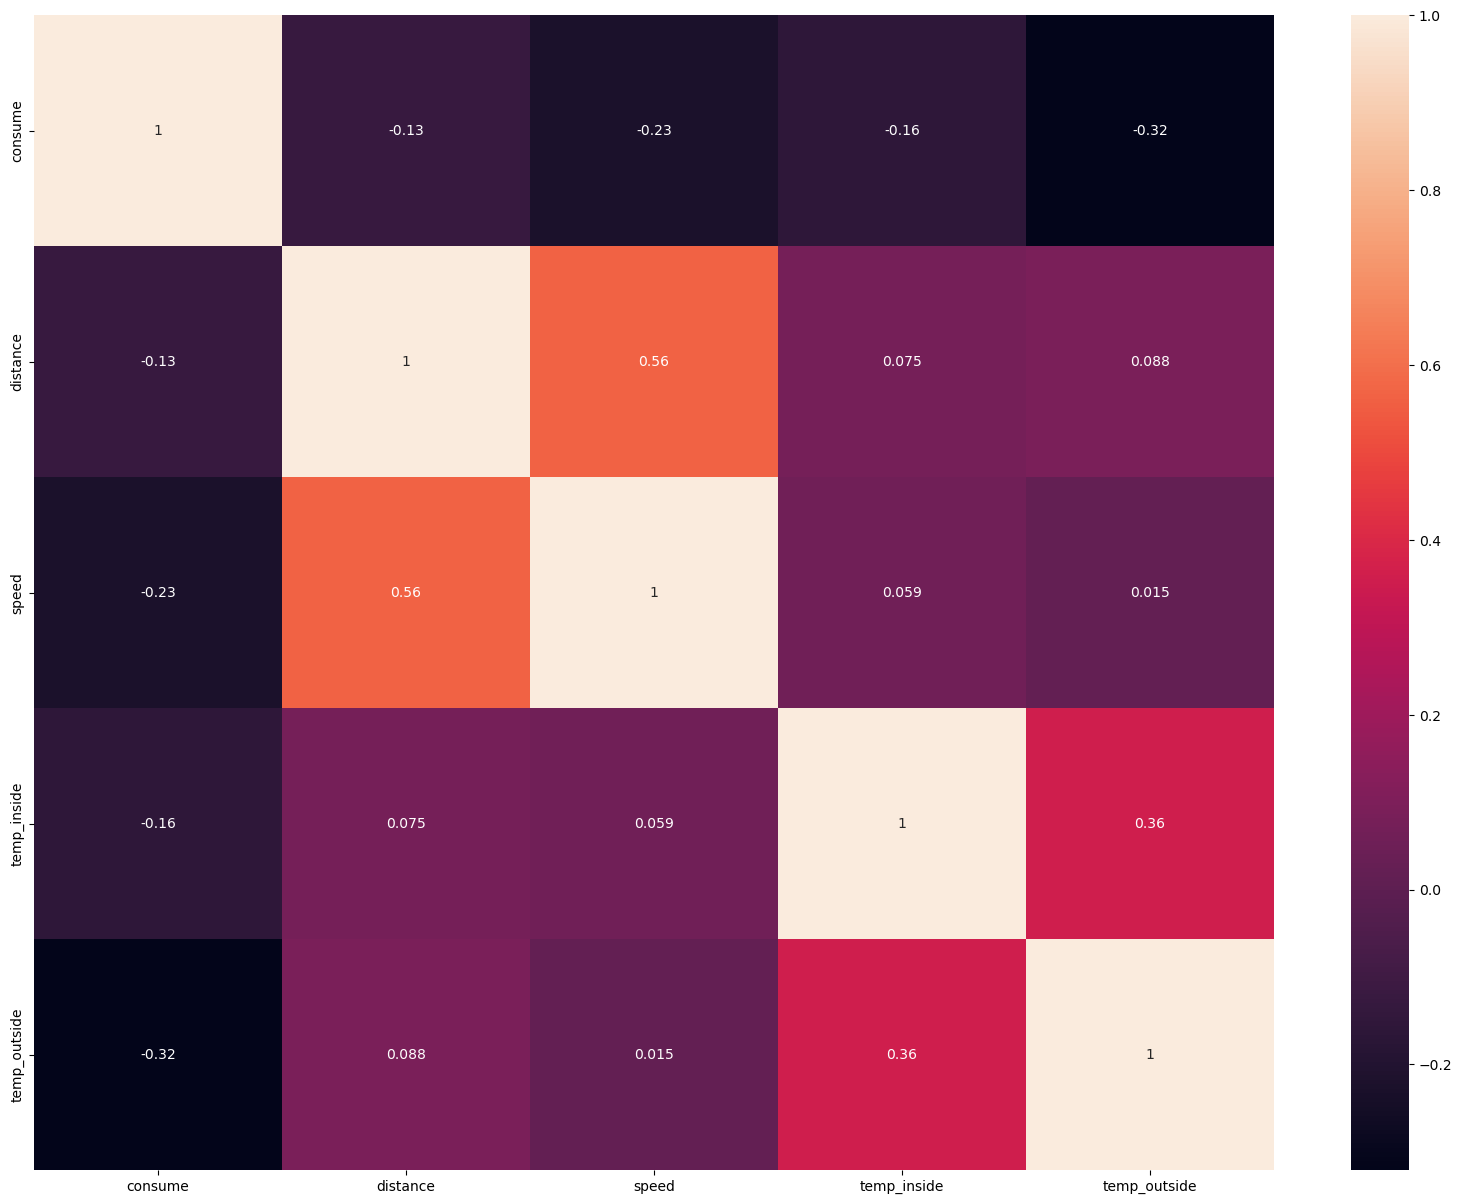

In [522]:
#correlation
Collinearity = pd.concat((y, X), axis=1)
corr_matrix = Collinearity.corr()

#heatmap
fig, ax = plt.subplots(figsize=(20,15))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [523]:
X.head()

,distance,speed,temp_inside,temp_outside,gas_type,ac,rain,sun
0,28.0,26,21.5,12,E10,0,0,0
1,12.0,30,21.5,13,E10,0,0,0
2,11.2,38,21.5,15,E10,0,0,0
3,12.9,36,21.5,14,E10,0,0,0
4,18.5,46,21.5,15,E10,0,0,0


## Apply Model on the whole dataset:

In [524]:
numericals_full_scaled = transformer.transform(X_num)
numericals_full_scaled = pd.DataFrame(numericals_full_scaled, columns=X_num.columns)

In [472]:
X_cat.head()

,gas_type,ac,rain,sun
0,E10,0,0,0
1,E10,0,0,0
2,E10,0,0,0
3,E10,0,0,0
4,E10,0,0,0


In [525]:
X_cat['gas_type'] = X_cat["gas_type"].map({"SP98" : 0, "E10" : 1})

In [526]:
X_cat.head()

,gas_type,ac,rain,sun
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [527]:
X_full_processed = np.concatenate((X_cat, numericals_full_scaled),axis=1)

In [528]:
X_full_processed.shape

(388, 8)

In [529]:
model = RandomForestRegressor(criterion= 'squared_error', min_samples_leaf= 2) 

#Fitting the model
model.fit(X_train_processed, y_train)

#Predicted target trainvalues
y_pred_train = model.predict(X_train_processed)
#Predicted target testvalues
y_pred_test = model.predict(X_test_processed)

r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_pred_test, y_test)
mae_test = mean_absolute_error(y_pred_test, y_test)

In [530]:
y_pred_full = model.predict(X_full_processed)

In [531]:
data['consume_pred'] = y_pred_full

### Save the dataset to csv.file

In [532]:
display(data.shape)
#save intermediate results:
data.to_csv('data_predicted.csv', index=False)

(388, 10)

## Store into SQL

In [ ]:
# prep: import modules and get pwd
import pymysql
from sqlalchemy import create_engine
from sqlalchemy import MetaData
from sqlalchemy_utils import database_exists, create_database
import getpass  # To get the password without showing the input
password = getpass.getpass()

In [ ]:
#create connection to SQL; create a new database
connection_string = 'mysql+pymysql://root:' + password + '@localhost/mid_bootcamp_project'
engine = create_engine(connection_string)

if not database_exists(engine.url):
    create_database(engine.url)

#create tables form existing pandas df
data.to_sql('data', engine, if_exists = 'replace')

## reread the file from SQL

In [ ]:
# get the data
query = '''select *
from data d;'''

data = pd.read_sql_query(query, engine)
data.head()

For further analysis:

To enrich the dataset, I would screen the internet to obtain related data by web scraping or with APIs.
I would look to differentiate by vehicle type 